In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

In [2]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

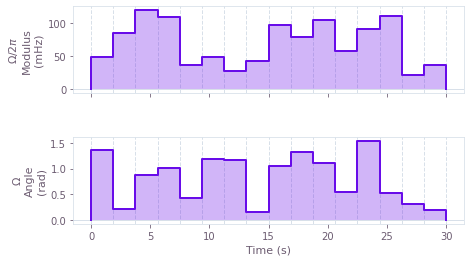

In [10]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [ ]:
# measurements = experiment_results.measurements
# for k, measurement_counts in enumerate(measurements):
#     print(f"control #{k}: {measurement_counts}")

# Rabi Frequency study

In [194]:
# Hardware input Rabi rate is a number in [-1, 1]
def rabi_experiment(rabi_rate, max_time=40., n_samples=100, shot_count=10_000):
    min_time = 1e-10
    durations = np.linspace(min_time, max_time, n_samples)

    controls = [
        {"duration": duration, "values": np.array([rabi_rate])}
        for duration in durations
    ]
    
    experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=controls,
        shot_count=shot_count
    )
    
    return  {t: m for t, m in zip(durations, experiment_results.measurements)}

In [216]:
shot_count = 1_000
measurements = rabi_experiment((-1+1j) / np.sqrt(2), shot_count=1_000)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


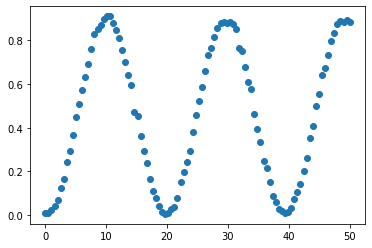

In [235]:
plt.scatter(measurements.keys(), [m.count(1) / shot_count for m in measurements.values()])
plt.scatter(durations, [m.count(1) / shot_count for m in experiment_results.measurements])

In [ ]:
omegas = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for omega in omegas:
    print(f'Case: Ω = {omega}')
    measurements = rabi_experiment(omega)
    
    with open(f'data/rabi_{omega}.dat', 'w') as file:
        for t, m in measurements.items():
            frequency = m.count(0)
            file.write(f'{t}\t{frequency}\n')

We fit the curve with Gnuplot, as such (typo: we meant \Omega = -1.0 in the picture)

![](data/rabi_fit.png)

We obtained the following frequencies as a function of the hardware input $\Omega$, with the fit $f(\Omega) = 0.0524(9) \Omega + 0.000(6).$

![](data/hardware_rabi_calibration.png)

It seems the approximation is better closer to $\lvert \Omega \rvert = 1$, so we will attempt to use those values in the Hamiltonian design.

# Leakage study

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 18s.


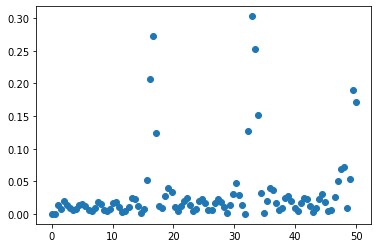

In [197]:
measurements = rabi_experiment(1., max_time=60.)

In [ ]:
leakage_rate = [m.count(2) / sum(bool(x) for x in m) for m in measurements.values()]
plt.scatter(durations, leakage_rate)

In [239]:
# Find the "median" value of the rate at which |2> is measured
# normalized by the rate at which |1> is measured

two_rates = sorted(m.count(2) / sum(bool(x) for x in m) for m in experiment_results.measurements)
two_rates = sum(sorted(leakage_rate)[N//2-1:N//2+1]) / 2
print(f"Median measured |2> rate (as a function of |1> measurements as a function of time)")
print(f"{two_rates:%}")

Median measured |2> rate (as a function of |1> measurements as a function of time)
1.462235%


# Designing the two gates

## NOT gate

Using the experimental study before, we see that \Omega = -1.0 is a good approximation for a NOT gate (the error is ~1%).

The period of the rabi oscillation was found to be ~19.5s by fitting the curve hardware input vs. measurement frequency of |0>.

Therefore, our simple NOT may be a constant pulse with the duration of a half-period.

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 23s.


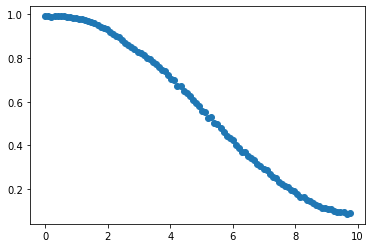

In [289]:
period = 19.4887485853892 # For Ω = -1.0

gate_time = period / 2
values = np.array([-1])  # One part Y for two parts X

durations = np.linspace(1e-10, gate_time, 100)

shot_count = 10_000
experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=[{"duration": duration, "values": values}
                 for duration in durations],
        shot_count=shot_count
)

plt.scatter(durations, [m.count(0) / shot_count for m in experiment_results.measurements])

## Hadamard gate

We use a simple approach for the Hadamard as well. We assume the Rabi oscillations are a good approximation.

We could use the approach of evolving
  - Y rotation for duration t = period / 8
  - X rotation for duration t = period / 4
  
However, we hope to do better by using a more symmetric evolution. Playing around the parameters we figure that
  -  Y rotation for duration t = period / 16
  -  X rotation for duration t = period / 4
  -  -Y rotation for duration t = period / 16
  
Also results in a Hadamard gate. We "borrow" a bit of the Y rotation to be undone at the end.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 15s.


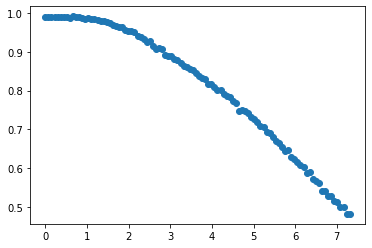

In [291]:
period = 19.4887485853892 # For |Ω| = 1

gate_time = 6 * period / 16
values = np.array([1j, 1, 1, 1, 1, -1j])  # One part Y for two parts X
# values = np.array([1j, 1, 1])  # One part Y for two parts X

durations = np.linspace(1e-10, gate_time, 100)

shot_count = 10_000
experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=[{"duration": duration, "values": values}
                 for duration in durations],
        shot_count=shot_count
)

plt.scatter(durations, [m.count(0) / shot_count for m in experiment_results.measurements])